In [1]:
import scanpy as sc
import scvelo as scv
import pandas as pd

In [3]:
adata = sc.read('../../../../hindbrain_pons/OligoPons_metafromSten.loom')
embedding= pd.read_csv('../../../../hindbrain_pons/embedding.csv', sep=',', index_col=0)
annotations = pd.read_csv('../../../../hindbrain_pons/annotations.csv', sep=',', index_col=0)


adata.obs['index'] = adata.obs['Sample_Index'].index.values
adata = adata[adata.obs['index'].isin(embedding.index.values)]
annotation_cats = pd.Categorical(annotations.values.flatten().astype(str))
annotations_cats_fixed = annotation_cats.rename_categories({'2': 'NFOLS', '3': 'MFOLS', '6':'COPs'})
adata.obs['annotation'] = annotations_cats_fixed
adata.obsm['X_tsne']= embedding.values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


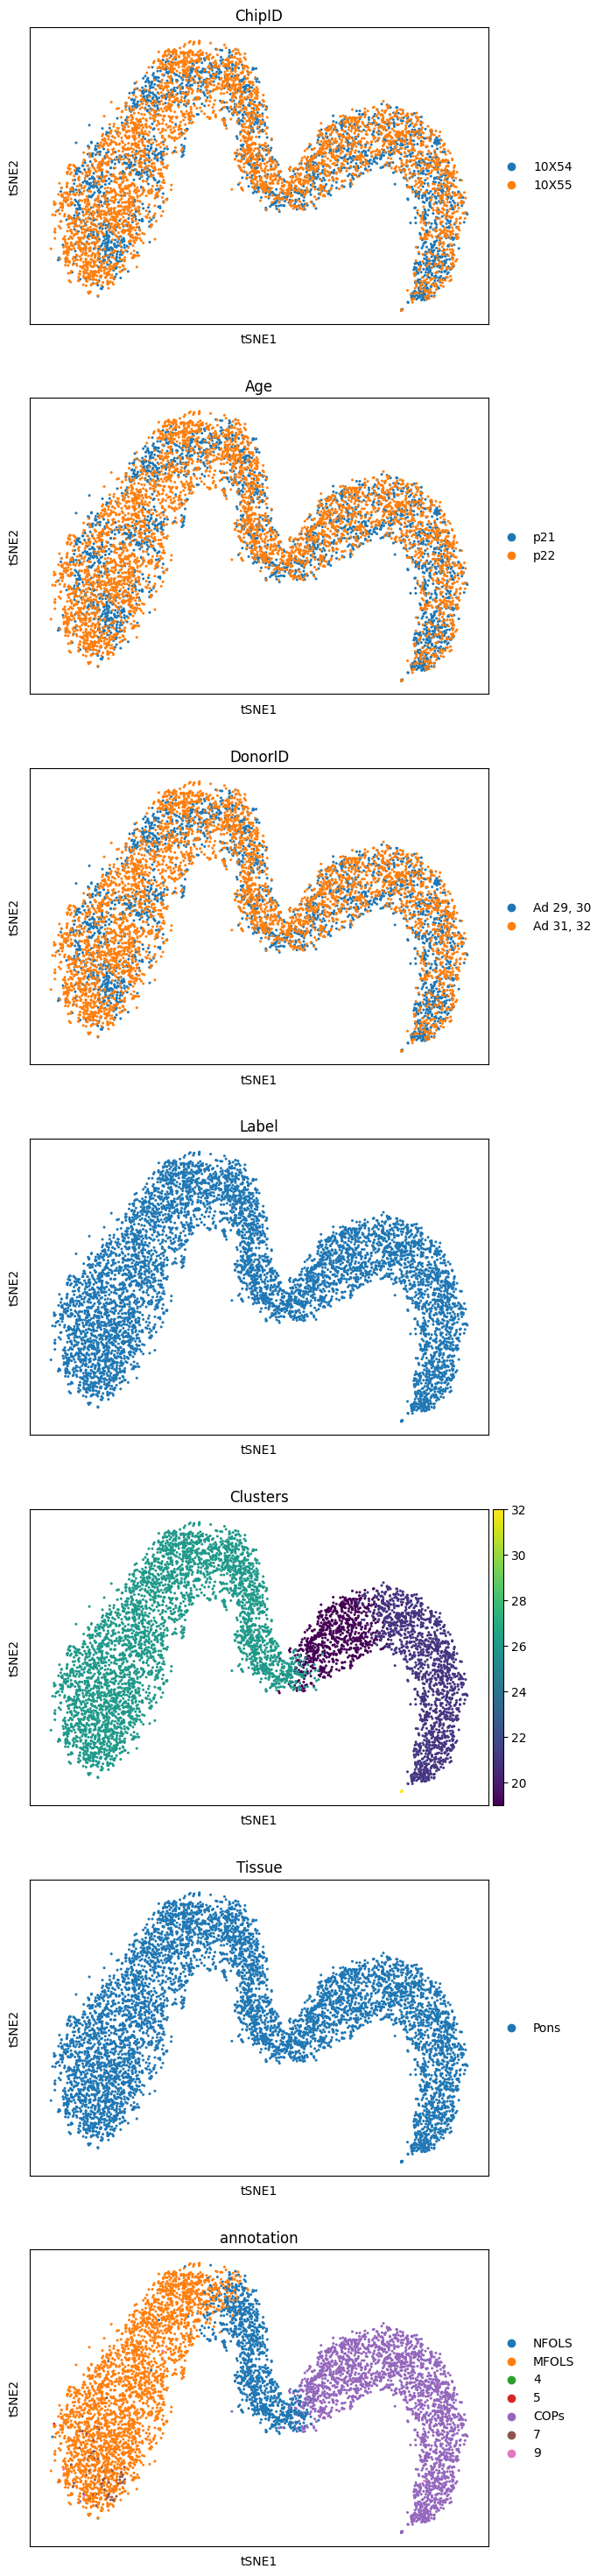

In [4]:
sc.pl.tsne(adata, color=['ChipID', 'Age', 'DonorID', 'Label', 'Clusters', 'Tissue', 'annotation'], ncols=1)

In [5]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.pca(adata)
scv.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 23116 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:11) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [6]:
scv.tl.recover_dynamics(adata, n_jobs=12)
scv.tl.velocity(adata, mode='dynamical', vkey='dynvelo', n_jobs=12)
scv.tl.velocity(adata, mode='stochastic', vkey='stocvelo', n_jobs=12)

recovering dynamics (using 12/16 cores)


  0%|          | 0/757 [00:00<?, ?gene/s]

    finished (0:01:51) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'dynvelo', velocity vectors for each individual cell (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'stocvelo', velocity vectors for each individual cell (adata.layers)


In [7]:
scv.tl.velocity_graph(adata, vkey='dynvelo', n_jobs=12)
scv.tl.velocity_graph(adata, vkey='stocvelo', n_jobs=12)

computing velocity graph (using 12/16 cores)


  0%|          | 0/6253 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'dynvelo_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 12/16 cores)


  0%|          | 0/6253 [00:00<?, ?cells/s]

    finished (0:00:07) --> added 
    'stocvelo_graph', sparse matrix with cosine correlations (adata.uns)


In [8]:
scv.tl.velocity_embedding(adata, vkey='dynvelo')
scv.tl.velocity_embedding(adata, vkey='stocvelo')

computing velocity embedding
    finished (0:00:00) --> added
    'dynvelo_tsne', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'stocvelo_tsne', embedded velocity vectors (adata.obsm)


In [9]:
cluster_edges = [
    ('COPs', 'NFOLS'), 
    ('NFOLS', 'MFOLS')]

In [10]:
import latentvelo as ltv

scv.tl.velocity_embedding(adata, vkey='dynvelo', basis='pca')
dyn_pca = ltv.ev.cross_boundary_correctness(adata,
                                  'annotation', 'dynvelo_pca', cluster_edges, x_emb='X_pca', 
                                   majority_vote=True, return_raw=True)

scv.tl.velocity_embedding(adata, vkey='stocvelo', basis='pca')
stoc_pca = ltv.ev.cross_boundary_correctness(adata,
                                  'annotation', 'stocvelo_pca', cluster_edges, x_emb='X_pca', 
                                   majority_vote=True, return_raw=True)

Global seed set to 0


computing velocity embedding
    finished (0:00:01) --> added
    'dynvelo_pca', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:01) --> added
    'stocvelo_pca', embedded velocity vectors (adata.obsm)


In [11]:
adata.obsm['X_pca_10'] = adata.obsm['X_pca'][:,:10]

scv.tl.velocity_embedding(adata, vkey='dynvelo', basis='pca_10')
dyn_pca_10 = ltv.ev.cross_boundary_correctness(adata,
                                  'annotation', 'dynvelo_pca_10', cluster_edges, x_emb='X_pca_10', 
                                   majority_vote=True, return_raw=True)

scv.tl.velocity_embedding(adata, vkey='stocvelo', basis='pca_10')
stoc_pca_10 = ltv.ev.cross_boundary_correctness(adata,
                                  'annotation', 'stocvelo_pca_10', cluster_edges, x_emb='X_pca_10', 
                                   majority_vote=True, return_raw=True)

computing velocity embedding
    finished (0:00:00) --> added
    'dynvelo_pca_10', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'stocvelo_pca_10', embedded velocity vectors (adata.obsm)


In [12]:
dyn_pca_iccoh = ltv.ev.inner_cluster_coh(adata,
                                  'annotation', 'dynvelo_pca', return_raw=True, layer=False)
dyn_pca_10_iccoh = ltv.ev.inner_cluster_coh(adata,
                                  'annotation', 'dynvelo_pca_10', return_raw=True, layer=False)


stoc_pca_iccoh = ltv.ev.inner_cluster_coh(adata,
                                  'annotation', 'stocvelo_pca', return_raw=True, layer=False)
stoc_pca_10_iccoh = ltv.ev.inner_cluster_coh(adata,
                                  'annotation', 'stocvelo_pca_10', return_raw=True, layer=False)

In [13]:
import numpy as np

np.save("fits/hindbrain_pons_dynvelo_pca.npy", dyn_pca)
np.save("fits/hindbrain_pons_dynvelo_pca_10.npy", dyn_pca_10)

np.save("fits/hindbrain_pons_stocvelo_pca.npy", stoc_pca)
np.save("fits/hindbrain_pons_stocvelo_pca_10.npy", stoc_pca_10)

np.save("fits/hindbrain_pons_dynvelo_iccoh_pca.npy", dyn_pca_iccoh)
np.save("fits/hindbrain_pons_dynvelo_iccoh_pca_10.npy", dyn_pca_10_iccoh)

np.save("fits/hindbrain_pons_stoc_iccoh_pca.npy", stoc_pca_iccoh)
np.save("fits/hindbrain_pons_stoc_iccoh_pca_10.npy", stoc_pca_10_iccoh)

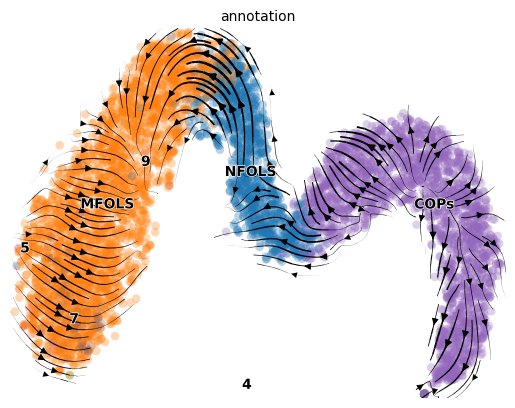

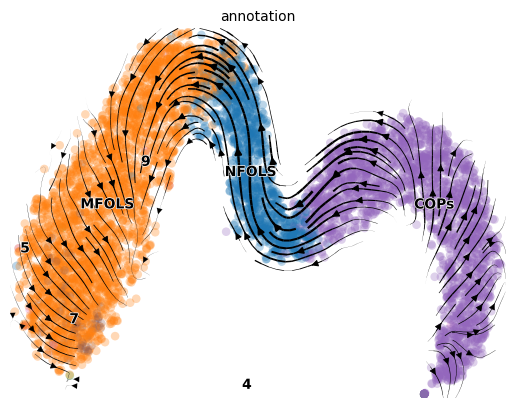

In [14]:
scv.pl.velocity_embedding_stream(adata, basis='tsne',vkey='dynvelo', color=['annotation'])
scv.pl.velocity_embedding_stream(adata, basis='tsne',vkey='stocvelo', color=['annotation'])